# Credit Risk Modellig

## Introduction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# from scikits.metrics import plot_confusion_matrix  # Remove this line, use sklearn.metrics instead
import os, sqlite3, warnings

In [23]:
application_test = pd.read_csv("application_test.csv")
application_train = pd.read_csv("application_train.csv")
bureau = pd.read_csv("bureau.csv")
previous_application = pd.read_csv("previous_application.csv")

The dataset contains no duplicates, null or nan values

In [24]:
conn = sqlite3.connect(":memory:")
application_test.to_sql("test", conn, index=False, if_exists="replace")
application_train.to_sql("train", conn, index=False, if_exists="append")
bureau.to_sql("bureau", conn, index=False, if_exists="replace")
previous_application.to_sql("previous_app", conn, index=False, if_exists="replace")

1670214

In [25]:
query = """
SELECT train.SK_ID_CURR, train.TARGET, train.AMT_INCOME_TOTAL, bureau.CREDIT_ACTIVE, bureau.AMT_CREDIT_SUM
FROM train
LEFT JOIN bureau ON train.SK_ID_CURR = bureau.SK_ID_CURR
LIMIT 10000
"""

df = pd.read_sql_query(query, conn)
df.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,CREDIT_ACTIVE,AMT_CREDIT_SUM
0,100002,1,202500.0,Active,31988.565
1,100002,1,202500.0,Active,450000.000
2,100002,1,202500.0,Closed,0.000
3,100002,1,202500.0,Closed,19071.000
4,100002,1,202500.0,Closed,40761.000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SK_ID_CURR        10000 non-null  int64  
 1   TARGET            10000 non-null  int64  
 2   AMT_INCOME_TOTAL  10000 non-null  float64
 3   CREDIT_ACTIVE     9681 non-null   object 
 4   AMT_CREDIT_SUM    9681 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 390.8+ KB


Target is the variable to use to train the model

In [26]:
# consider XGBoost approach to missing data

In [27]:
# study the composition of each variable
variables = ["TARGET", "AMT_INCOME_TOTAL", "CREDIT_ACTIVE", "AMT_CREDIT_SUM"]
for var in variables:
    null_count = df[var].isnull().sum()
    nan_count = df[var].isna().sum()
    duplicate_count = df[var].duplicated().sum()
    print(f"Variable:{var}")
    print(f"Null values: {null_count}")
    print(f"NaN values: {nan_count}")
    print(f"Duplicate values: {duplicate_count}\n")

Variable:TARGET
Null values: 0
NaN values: 0
Duplicate values: 9998

Variable:AMT_INCOME_TOTAL
Null values: 0
NaN values: 0
Duplicate values: 9859

Variable:CREDIT_ACTIVE
Null values: 319
NaN values: 319
Duplicate values: 9996

Variable:AMT_CREDIT_SUM
Null values: 319
NaN values: 319
Duplicate values: 5165



In [28]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9681 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SK_ID_CURR        9681 non-null   int64  
 1   TARGET            9681 non-null   int64  
 2   AMT_INCOME_TOTAL  9681 non-null   float64
 3   CREDIT_ACTIVE     9681 non-null   object 
 4   AMT_CREDIT_SUM    9681 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 453.8+ KB


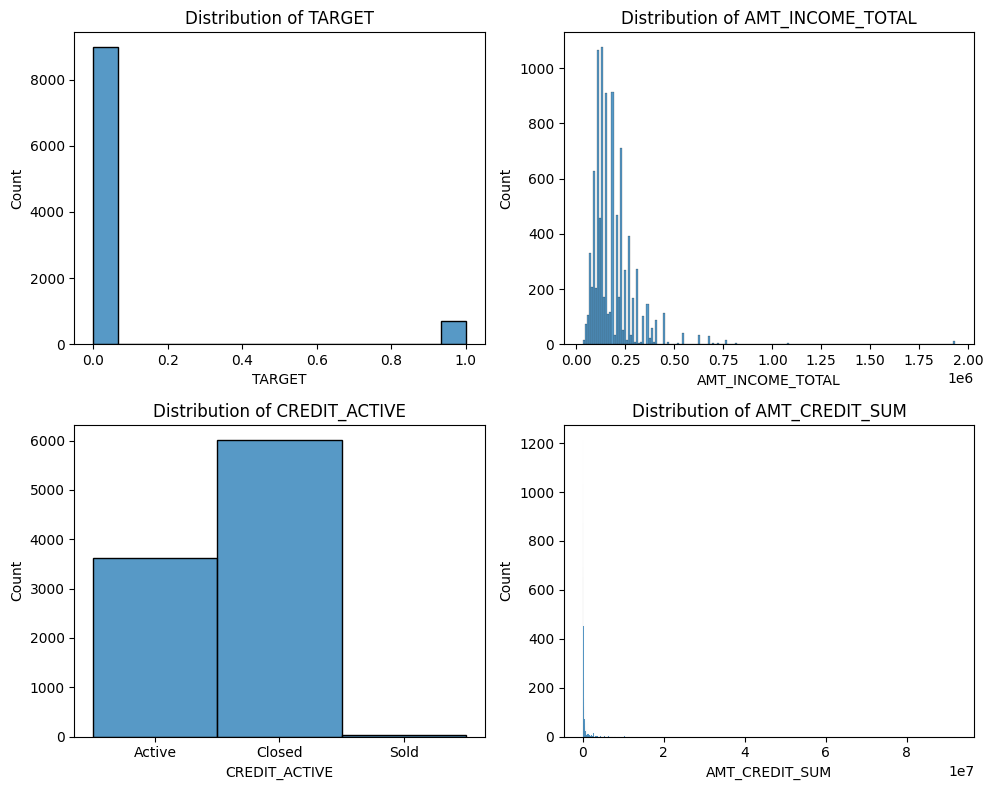

In [29]:
# print of the variable
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes array for easier iteration
axes = axes.flatten()

for i, var in enumerate(
    variables
):  # enumerate(variables) is just a handy Python function that lets you loop over both: 1) the index (position in the list) 2) the actual value (the variable name here)
    sns.histplot(df[var], ax=axes[i])
    axes[i].set_title(f"Distribution of {var}")

plt.tight_layout()
plt.show()

Distribution of target is inbalanced, having so an impact on the Recall of the model if no actions taken

In [30]:
# Data preprocessing
# CREDIT_ACTIVE is categorical, we need to convert it to numerical, plus adding morr categorical variables

X_encoded = pd.get_dummies(df, columns=["CREDIT_ACTIVE"], drop_first=True)
y = X_encoded["TARGET"]
X = X_encoded.drop(columns=["TARGET", "SK_ID_CURR"])  # Drop TARGET and ID column

XGBoost requires all the data to be either int, float or boolean, so we need to convert it accordingly.

In [31]:
X_encoded.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('bool')], dtype=object)

In [32]:
y.dtypes

dtype('int64')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, random_state=42, stratify=y
)

In [34]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic", seed=42)

clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

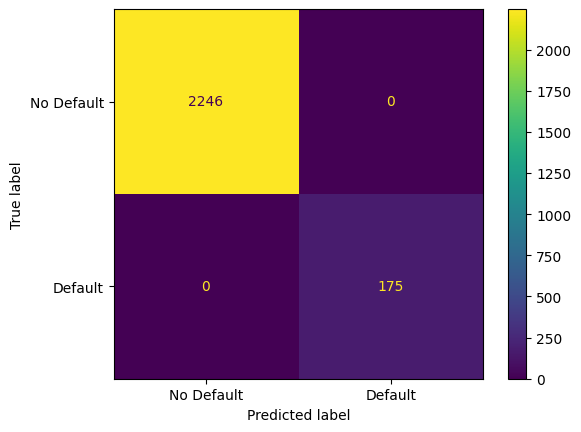

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    clf_xgb, X_test, y_test, values_format="d", display_labels=["No Default", "Default"]
)

Too perfect, overfitting ?

# Optimize Parameters using Cross Validation and GridSearch()

**XGBoost** has a lot of *hyperparameters*, parameters that we have to manual configure and are not determined by XGBoost itself, including `max_depth`, the maximum tree depth, `learning_rate`, the learning rate, or "eta", `gamma`, the parameter that encourages pruning, `reg_lambda`, the regularization parameter lambda and `scale_pos_weight`, which helps with imbalanced datasets. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the **Testing Dataset**.

**NOTE:** Since we have many hyperparameters to optimize, we will use `GridSearchCV()`. We specify a bunch of potential values for the hyperparameters and `GridSearchCV()` tests all possible combinations of the parameters for us.

In [22]:
# ## NOTE: When data are imbalanced, the XGBoost manual says...
# ## If you care only about the overall performance metric (AUC) of your prediction
# ##     * Balance the positive and negative weights via scale_pos_weight
# ##     * Use AUC for evaluation
# ## ALSO NOTE: I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
# ## in order to optimize parameters in a short period of time.

Cross-validation happens inside GridSearchCV via the cv= argument. Every time you instantiate it with a different param_grid, the estimator will train/evaluate every hyperparameter combination using the same cross-validation strategy.

GridSearchCV is a hyperparameter tuning tool in scikit-learn.

It systematically searches for the best combination of hyperparameter values for a given estimator (model) by trying all combinations you specify — hence the name “grid search.”

In [ ]:
def build_search(cv_folds: int = 5) -> GridSearchCV:
    """
    Builds and returns a GridSearchCV object for hyperparameter tuning of an XGBoost classifier.

    Args:
        cv_folds (int, optional): Number of cross-validation folds. Defaults to 5.
    """
    param_grid = {
        "max_depth": [3, 4, 5],
        "learning_rate": [0.1, 0.01, 0.05],
        "gamma": [0, 0.25, 1.0],
        "reg_lambda": [0, 1.0, 10.0],
        "scale_pos_weight": [
            1,
            3,
            5,
        ],  # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
    }

    estimator = xgb.XGBClassifier(
        objective="binary:logistic",
        tree_method="hist",
        random_state=42,
        use_label_encoder=False,
        n_jobs=-1,
    )

    search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv_folds,
        n_jobs=-1,
        verbose=1,
        return_train_score=True,
    )
    return search


# Build the GridSearchCV and run it
search = build_search(cv_folds=5)

# Note:
# GridSearchCV will call the estimator.fit(...) internally and does not always accept
# estimator-specific fit kwargs (like early_stopping_rounds, eval_set) when forwarded.
# Passing such kwargs to GridSearchCV.fit can raise errors depending on the estimator wrapper.
# To avoid the "unexpected keyword argument" error, call .fit without extra fit kwargs here.
search.fit(X_train, y_train)

# Print best parameters
print(search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}


c:\Users\pietr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:07:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
clf_xgb = xgb.XGBClassifier(
    seed=42,
    objective="binary:logistic",
    gamma=0,
    learning_rate=0.1,
    max_depth=3,
    reg_lambda=0,
    scale_pos_weight=1,
    subsample=0.9,
    colsample_bytree=0.5,
    ## the next two arguments set up early stopping:
    eval_metric="aucpr",
    early_stopping_rounds=10,
)

clf_xgb.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.17328
[1]	validation_0-aucpr:1.00000
[2]	validation_0-aucpr:1.00000
[3]	validation_0-aucpr:1.00000
[4]	validation_0-aucpr:1.00000
[5]	validation_0-aucpr:1.00000
[6]	validation_0-aucpr:1.00000
[7]	validation_0-aucpr:1.00000
[8]	validation_0-aucpr:1.00000
[9]	validation_0-aucpr:1.00000
[10]	validation_0-aucpr:1.00000
[11]	validation_0-aucpr:1.00000


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

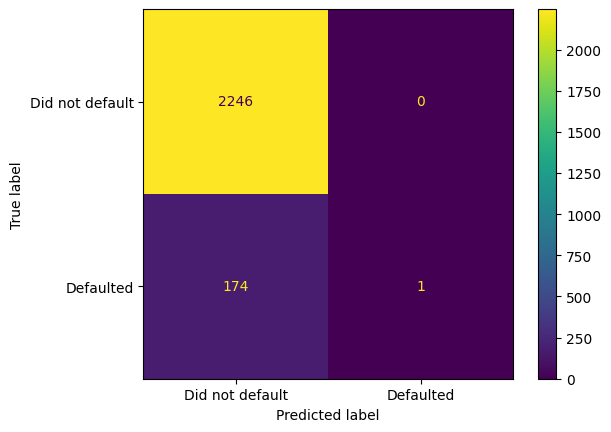

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    clf_xgb,
    X_test,
    y_test,
    values_format="d",
    display_labels=["Did not default", "Defaulted"],
)

In [ ]:
# Standardizing numerical features - use of Standardscaler, why ?